In [2]:
# load necessary libraries
import numpy as np
from scipy import ndimage
from scipy import misc
from scipy import stats
from scipy.signal import argrelextrema
import matplotlib.pyplot as plt
import matplotlib as mpl

In [3]:
# change plot size
mpl.rcParams['figure.figsize'] = (10, 10)

In [4]:
# read in an preprocess image
def readPrep(filename, plotIt, binaryThresh, smoothSigma):
    # read in image file
    let = misc.imread(filename)

    # read it in as grey
    grey1 = misc.imread(filename, flatten=True)
    grey = grey1.copy()

    # binarize
    if binaryThresh is not None:
        grey2 = grey1.copy()
        inds = grey2 > binaryThresh*255 
        grey2[inds] = 1
        grey2[np.logical_not(inds)] = 0
        grey = grey2.copy()

    # smooth
    if smoothSigma is not None:
        grey3 = ndimage.filters.gaussian_filter(input=grey, sigma=smoothSigma)
        grey = grey3.copy()
    
    if plotIt:        
        plt.imshow(let)
        plt.show()
        plt.imshow(grey1, cmap = plt.get_cmap('gray'))
        plt.show()
        plt.imshow(grey2, cmap = plt.get_cmap('gray'))
        plt.show()
        plt.imshow(grey3, cmap=plt.get_cmap('gray'))
        plt.show()
    return let, grey

In [5]:
# plot "histogram"
def yDensityHist(rowSums, pers):
    plt.plot(rowSums)
    ny = rowSums.shape[0]
    for pe in pers:
        p = np.percentile(rowSums, pe)
        plt.plot([0,ny], [p, p])
        plt.text(x=ny, y=p, s=str(pe))
    plt.text
    mpl.text.Text(200, 200, 'lovely')
    plt.show()

In [6]:
# get locations of the large drops using different cutoffs
def get_cutoffs(thresh):
    linebreaks = []
    linebreaks2 = []
    above = False
    curmin = np.inf
    mindex = 0
    for i in range(ny):
        curabove = grey_y[i] > thresh
        # method one - get the min of the region below
        if not above:
            if curabove:
                curmax = grey_y[i]
                maxdex = i
        else:
            if curabove:
                if grey_y[i] > curmax:
                    curmax = grey_y[i]
                    maxdex = i
            else:
                linebreaks.append(maxdex)
                curmax = np.inf

        # method 2 - get the center of the gap
        if not above and curabove:
            startloc = i
        if above and not curabove:
            linebreaks2.append(np.floor(np.mean([startloc, i])))

        above = curabove
    return linebreaks

In [7]:
# plot with the lines
def plotLines(img, breaks):
    plt.imshow(img)
    for i in range(len(breaks)):
        plt.plot([0,img.shape[1]], [breaks[i], breaks[i]])
    plt.show()

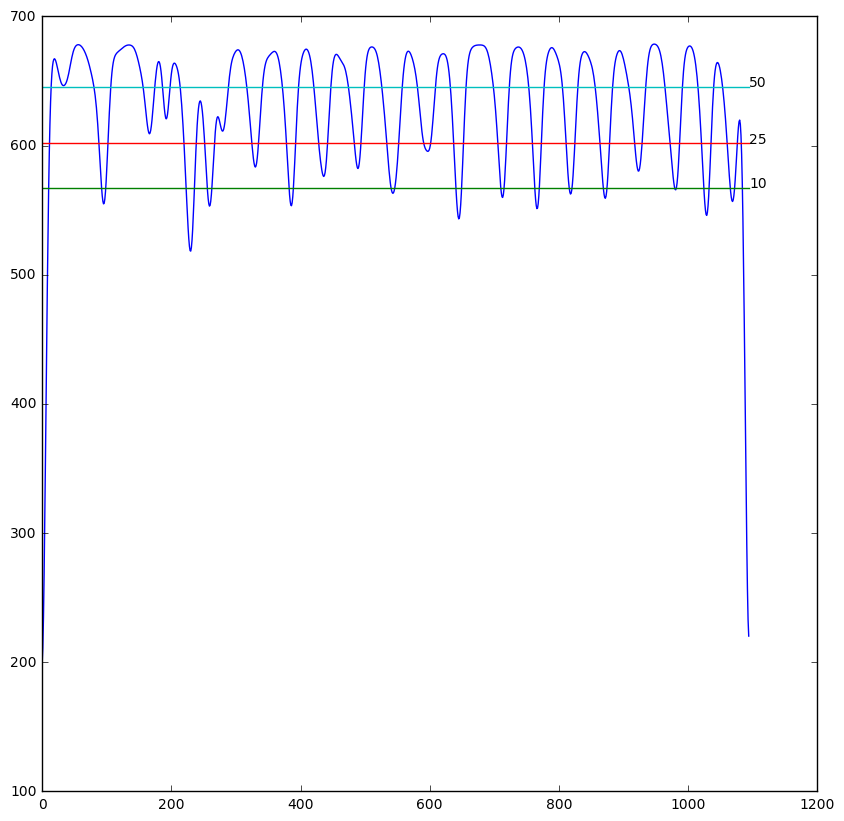

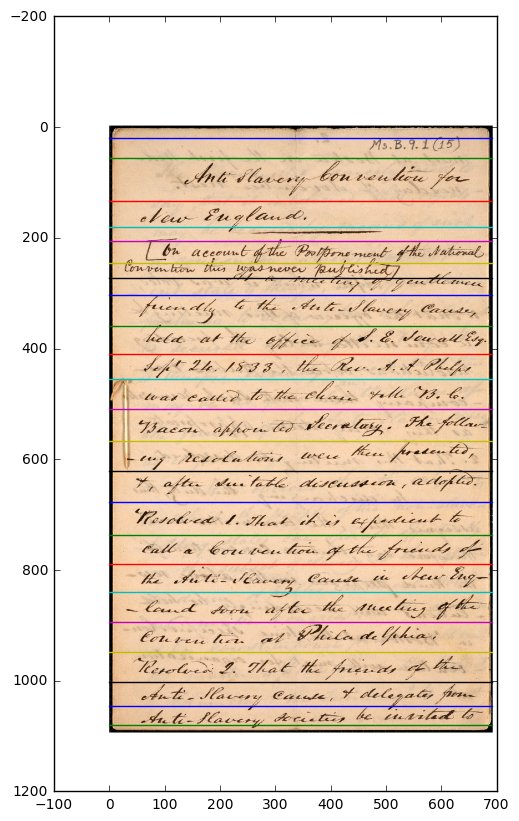

In [20]:
# do everything for the easy image
let, grey = readPrep(filename='images/easy.jpg', plotIt=False, binaryThresh=0.6, smoothSigma=5.0)
grey_y = np.sum(grey, 1) # get rows as sum
yDensityHist(rowSums=grey_y, pers=[10, 25, 50]) # plot "histogram"
linebreaks = argrelextrema(grey_y, np.greater) # get local maxima from data
plotLines(img=let, breaks=linebreaks) # plot it all

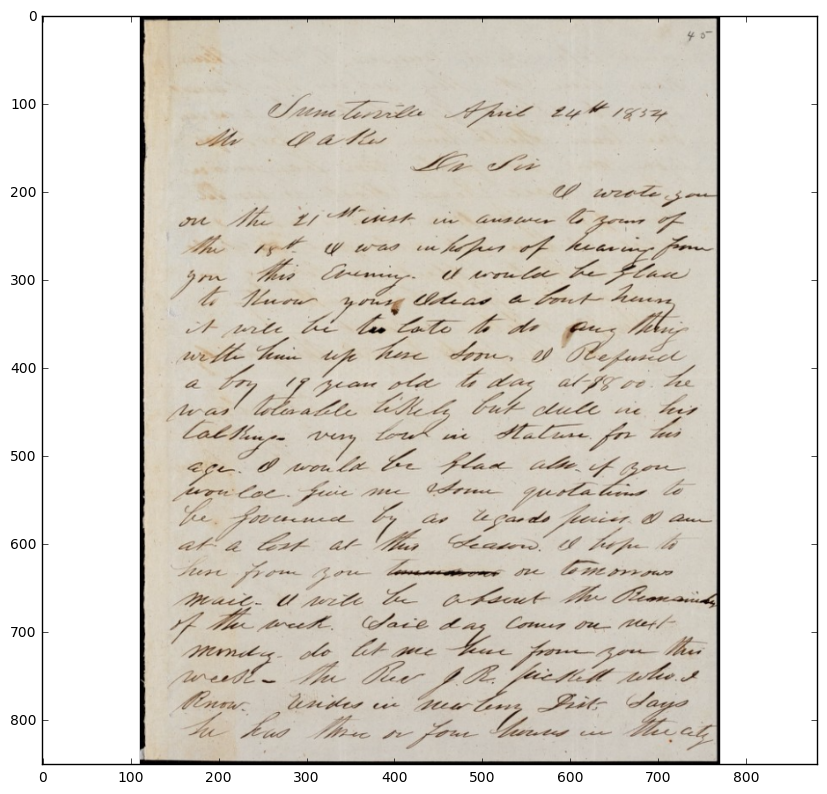

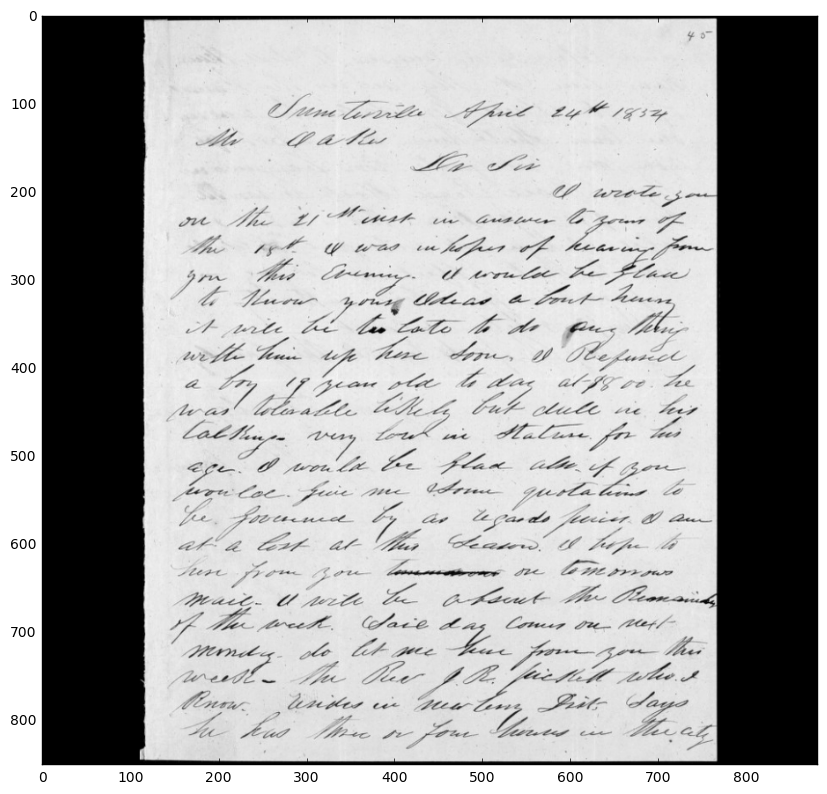

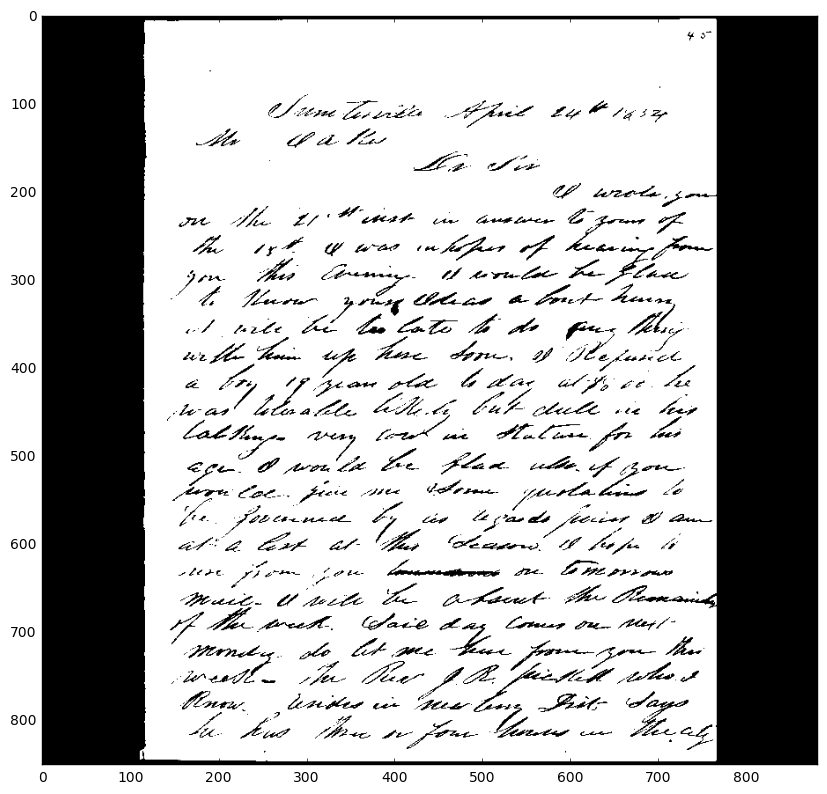

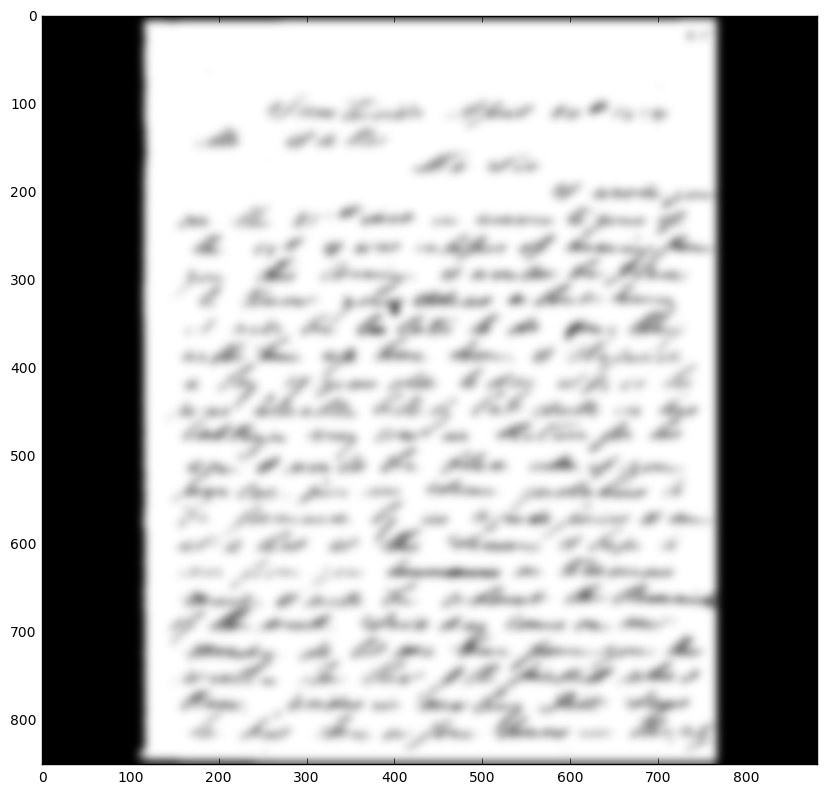

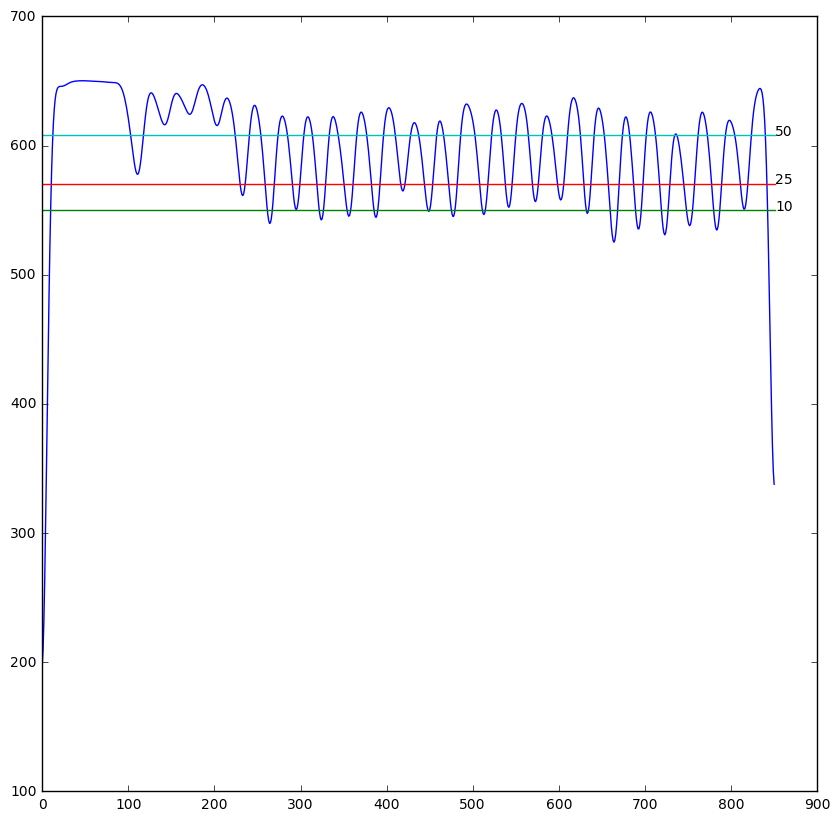

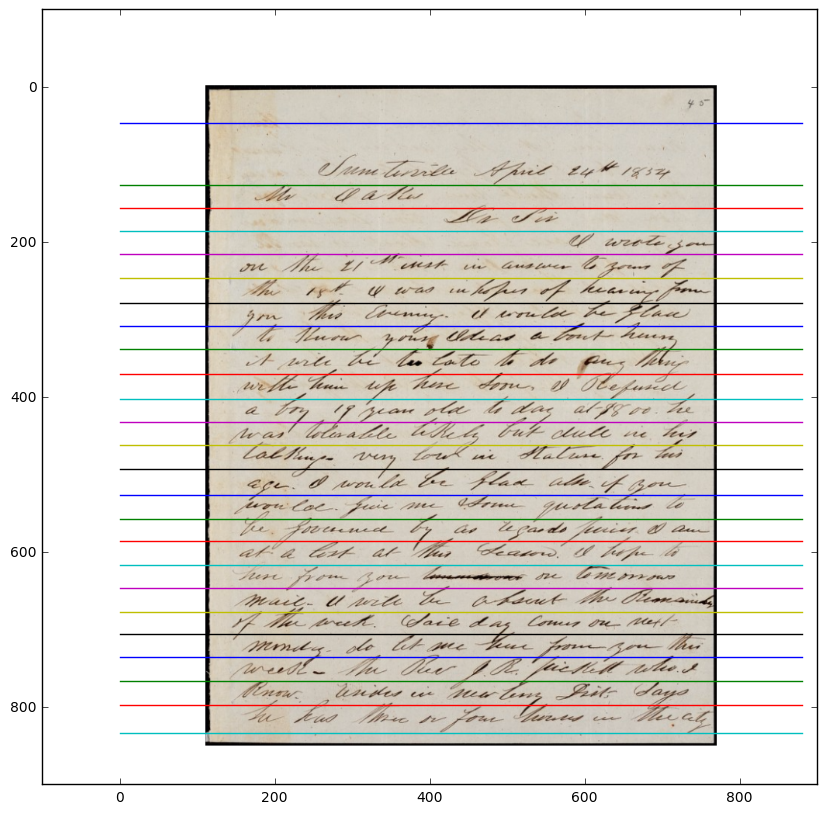

In [10]:
# do everything for the medium image
let, grey = readPrep(filename='images/medium.png', plotIt=True, binaryThresh=0.6, smoothSigma=5.0)
grey_y = np.sum(grey, 1) # get rows as sum
yDensityHist(rowSums=grey_y, pers=[10, 25, 50]) # plot "histogram"
linebreaks = argrelextrema(grey_y, np.greater) # get local maxima from data
plotLines(img=let, breaks=linebreaks) # plot it all

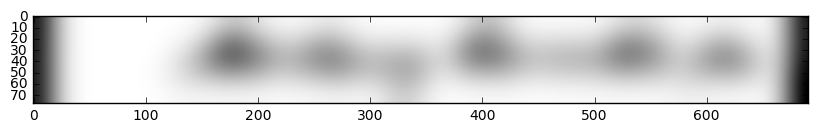

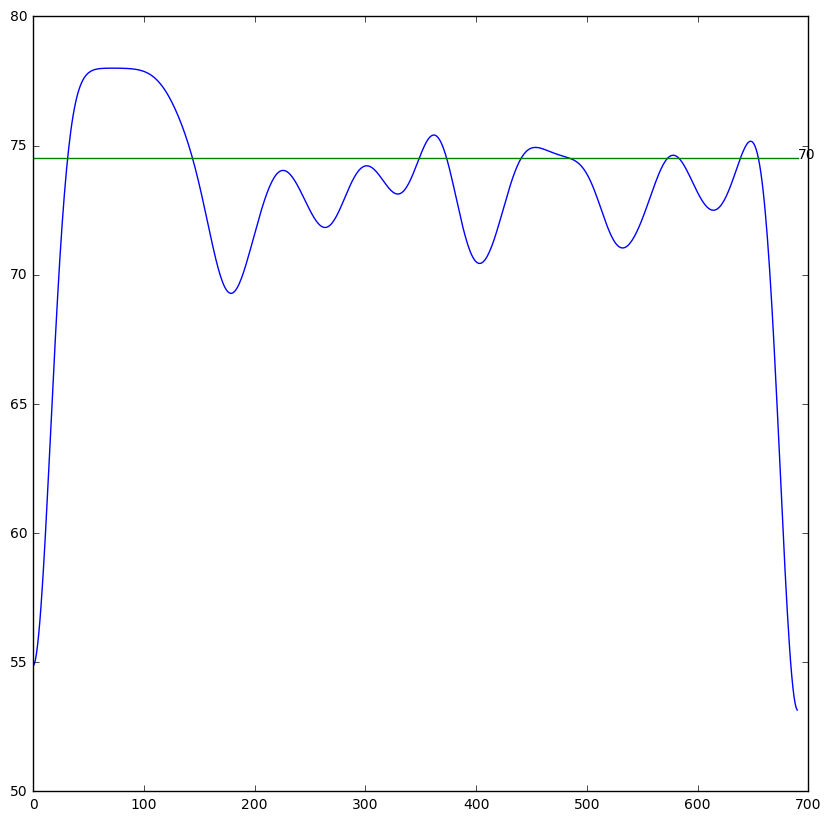

(array([ 71, 226, 301, 362, 454, 578, 648]),)

In [21]:
# now try to split into words
breaks = linebreaks[0].copy()
breaks = np.insert(breaks, 0, 0)
breaks = np.append(breaks, grey.shape[0])
# for i in range(len(breaks)):
i = 2
chunk = grey[breaks[i]:breaks[i+1],]
# chunk = ndimage.filters.gaussian_filter(input=chunk, sigma=15) # smooth it even futher
plt.imshow(chunk, cmap=plt.get_cmap('gray'))
plt.show()
chunk_x = np.sum(chunk, 0)
yDensityHist(rowSums=chunk_x, pers = [70])
wordbreaks = argrelextrema(chunk_x, np.greater)
wordbreaks